In [2]:
import sys
sys.path.append('/Users/vdk/GeneveWork/Code/calibpipe-main-calibpipe/')
from astropy.io import ascii
import numpy as np
import pandas as pd
import matplotlib
import csv
import scipy
import matplotlib.pyplot as plt
from seaborn import histplot
import random
import copy
from os import path, makedirs
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from ctapipe.containers import MuonEfficiencyContainer
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.core import TelescopeComponent
from ctapipe.core.traits import (
    List,
    Int,
    FloatTelescopeParameter,
    TelescopeParameter,
    Unicode,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import MuonRingFitter, MuonIntensityFitter
from traitlets.config import Config
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from traitlets.config.loader import Config, FileConfigLoader, JSONFileConfigLoader
import pathlib
from calibpipe.throughput import MuonCalibrator
from traitlets.config import Config
from astropy.time import Time
from astropy.coordinates import EarthLocation,SkyCoord, AltAz 
from traitlets.config import Config
import time
from pyirf import simulations,utils, spectral




In [1]:
2+2

4

In [2]:
int_cut = 0.3
min_pixel = 70

# MuonIntensityFitter : 
#   hole_radius_m : [["type", "LST_*", 0.308]]

muon_processor_config = Config({"MuonProcessor": 
                                {"RingQuery": 
                                 {"quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.5"],
                                                        ["ring_completeness", "parameters.completeness > 0.5"]]}}})

#muon_processor_config = Config({"MuonProcessor":
#                                {"ImageParameterQuery" :
#                                {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
#                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

muon_processor_config_2 = Config({"MuonProcessor":
                                {"ImageParameterQuery" :
                                 {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})


muon_processor_config = Config({
                                "MuonProcessor": {
                                    "RingQuery": {
                                        "quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.3"],
                                                        ["ring_completeness", "parameters.completeness > 0.3"]]},
                                    "ImageParameterQuery" : {
                                        "quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]},
                                    "MuonIntensityFitter" : {
                                        "hole_radius_m" : [["type", "LST_*", 0.308]]
                                    }}})

checker = 0
event_container = {}
t1 = time.perf_counter(), time.process_time()
event_ids = []
impacts = []
widths = []
for k in range(1,101):
    filename = f'/Users/vdk/LST/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    print(filename)
    source = EventSource(filename)
    event_iterator = iter(source)
    keks = k*1000
    checker = 0
    for i,event in enumerate(event_iterator):
        for m in event.trigger.tels_with_trigger:
            checker += 1
            image_processor = ImageProcessor(source.subarray)
            muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
            #muon_processor = MuonProcessor(source.subarray)
            calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
            print(f"Non Muon Event Telescope with stereo trigger = {event.trigger.tels_with_trigger}")
            calib(event)
            image_processor(event)
            muon_processor(event)
            for m in event.muon.tel.keys():
                if not np.isnan(event.muon.tel[m].efficiency.width):
                    #print("I am here")
                    # plt.figure(figsize = (9,6))
                    # camgeom = source.subarray.tel[1].camera.geometry
                    # title = f'event {event.index.event_id} in telescope {m}'
                    # disp = CameraDisplay(camgeom,title=title)
                    # #disp.image = event.r1.tel[m].waveform.sum(axis = 1)
                    # disp.image = event.dl1.tel[m].image
                    # disp.cmap = plt.cm.Reds
                    # disp.add_colorbar()
                    # disp.set_limits_percent(95)
                    # plt.show()
                    print(f"Muon Event Telescope with stereo trigger = {event.trigger.tels_with_trigger}")
                    event_container[keks+i] = event
                    event_ids.append(event.index.event_id)
                    impacts.append(event.muon.tel[m].efficiency.impact)
                    widths.append(event.muon.tel[m].efficiency.width)
    t2 = time.perf_counter(), time.process_time()
    print("checker = ", checker)   
#plt.close()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

/Users/vdk/LST/4LSTmuons/simtel_run101_muon.simtel.gz
Non Muon Event Telescope with stereo trigger = [3]
Non Muon Event Telescope with stereo trigger = [3]
Non Muon Event Telescope with stereo trigger = [4]
Non Muon Event Telescope with stereo trigger = [2]
event_id 48900 has center_fov_lon = -0.7445543723786515 deg and center_fov_lon = 0.23773274748477383 deg, radius = 1.188495021310819 deg
Muon parameters = {'impact': <Quantity 7.10442735 m>,
 'impact_x': <Quantity -4.32214863 m>,
 'impact_y': <Quantity 5.63843234 m>,
 'optical_efficiency': 0.21501509579369316,
 'width': <Quantity 0.04373853 deg>}
RING SIZE with lstchain mask 2636.4912109375
RING SIZE ORIGINAL 2634.87353515625
Muon Event Telescope with stereo trigger = [2]
Non Muon Event Telescope with stereo trigger = [2]
Non Muon Event Telescope with stereo trigger = [4]
Non Muon Event Telescope with stereo trigger = [4]
Non Muon Event Telescope with stereo trigger = [4]
Non Muon Event Telescope with stereo trigger = [2]
Non Muon E

KeyboardInterrupt: 

In [8]:

unusable_pixels_hg = event.mon.tel[tel_id].calibration.unusable_pixels[0]
unusable_pixels_lg = event.mon.tel[tel_id].calibration.unusable_pixels[1]

bad_pixels = unusable_pixels_hg | unusable_pixels_lg

event.dl1.tel[tel_id] *= ~bad_pixels


{'calibration': {'dc_to_pe': None,
                 'n_pe': None,
                 'pedestal_per_sample': None,
                 'time': <Quantity nan s>,
                 'time_correction': None,
                 'time_max': <Quantity nan s>,
                 'time_min': <Quantity nan s>,
                 'unusable_pixels': None},
 'flatfield': {'charge_mean': None,
               'charge_median': None,
               'charge_median_outliers': None,
               'charge_std': None,
               'charge_std_outliers': None,
               'n_events': 0,
               'relative_gain_mean': None,
               'relative_gain_median': None,
               'relative_gain_std': None,
               'relative_time_median': None,
               'sample_time': <Quantity 0. s>,
               'sample_time_max': <Quantity nan s>,
               'sample_time_min': <Quantity nan s>,
               'time_mean': None,
               'time_median': None,
               'time_median_outliers': N

In [44]:
for items in event_container[1003].r1.tel.items():
    print()

<class 'tuple'>
<class 'tuple'>


In [53]:
event_container[1003].r1.tel[2].waveform.shape

(1855, 40)

In [75]:
mask = np.array([True,True,False])
bad_pixels = test*[~mask]
test = np.array([1,2,3])

In [76]:
test *= ~mask
test

array([0, 0, 3])

In [ ]:
#print("all events = ", all_events)
#print("stereo = ", stereo)
print("muons = ", len(event_container))
print("muons events = ", event_container.keys())
#for i in event_container_protons:
#    print(i)

opt_eff_m = []
for i in event_container:
    for m in event_container[i].trigger.tels_with_trigger:
        if not np.isnan(event_container[i].muon.tel[m].efficiency.optical_efficiency) and event_container[i].muon.tel[m].efficiency.optical_efficiency < 100:
            opt_eff_m.append(event_container[i].muon.tel[m].efficiency.optical_efficiency)

print("mean = ", np.mean(opt_eff_m))
print("std = ", np.std(opt_eff_m))
print("len = ", len(opt_eff_m))
print(f"event_ids = {event_ids}")


muons =  62
muons events =  dict_keys([1121, 2080, 3003, 6067, 6099, 9092, 9097, 10082, 10087, 10128, 13013, 13109, 15109, 17108, 19112, 21104, 22022, 28049, 32062, 32116, 33103, 34099, 34105, 35031, 37094, 37139, 39076, 41027, 45114, 47100, 52017, 52068, 52125, 53034, 55135, 57013, 61018, 63026, 63105, 64075, 65036, 67054, 69035, 73092, 73114, 74012, 76016, 83070, 84092, 84099, 84127, 87039, 87055, 87061, 88092, 90098, 91001, 92097, 93075, 95093, 100034, 100094])
mean =  0.22522706741594373
std =  0.01885382084416474
len =  62
event_ids = [1802500, 1274200, 76700, 1128200, 1661400, 1252900, 1322200, 1204100, 1264400, 1820500, 236800, 1976200, 1711400, 1736700, 1870100, 1513000, 268400, 848800, 899300, 1738000, 1282100, 1454000, 1545800, 658300, 1312400, 1956200, 1271700, 337900, 1918900, 1713900, 300800, 1114800, 1915000, 427300, 1838900, 237200, 327000, 471200, 1766700, 1117200, 516900, 978800, 536000, 1336200, 1632100, 151300, 238900, 1134900, 1336800, 1434500, 1776800, 448500, 5989

Text(0.5, 1.0, 'Widths of muons processed by CalibPipe method')

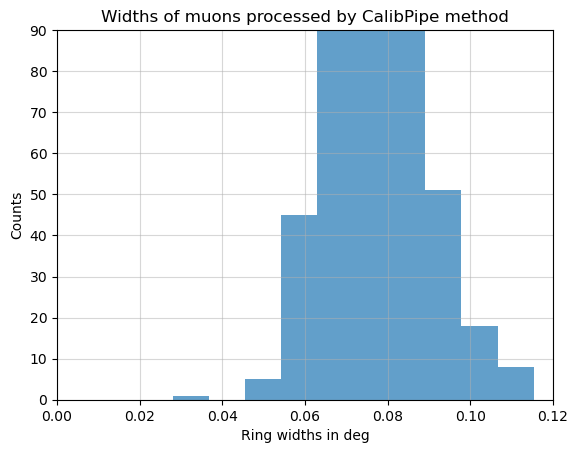

In [ ]:
plt.hist(widths, bins = 12, alpha = 0.7)
plt.ylabel('Counts')
plt.xlabel('Ring widths in deg')
plt.xlim(0,0.12)
plt.ylim(0,90)
plt.grid(alpha = 0.5)
plt.title("Widths of muons processed by CalibPipe method")

Text(0.5, 1.0, 'Impact of muons processed by CalibPipe method')

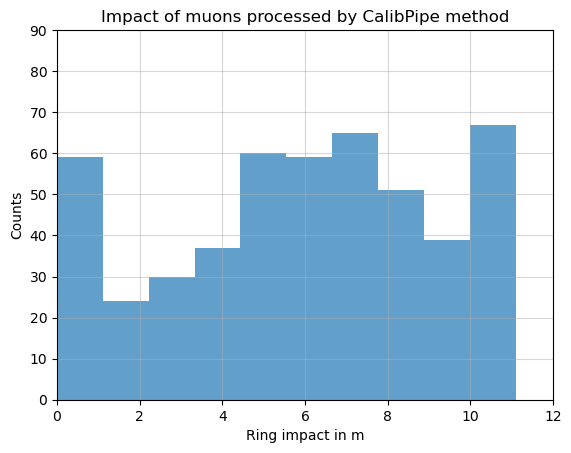

In [ ]:
plt.hist(impacts, bins = 10, alpha = 0.7)
plt.ylabel('Counts')
plt.xlabel('Ring impact in m')
plt.xlim(0,12)
plt.ylim(0,90)
plt.grid(alpha = 0.5)
plt.title("Impact of muons processed by CalibPipe method")

In [ ]:
energies = []
for k in range(1,100):
    filename = f'/Users/vdk/LST/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    source = EventSource(filename)
    event_iterator = iter(source)
    keks = k*1000
    for i,event in enumerate(event_iterator):
        energies.append(event.simulation.shower.energy.to_value())

Text(0.5, 1.0, 'Muon Energies')

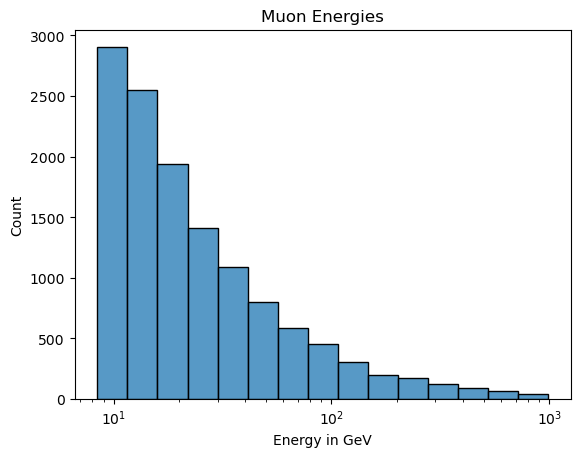

In [ ]:
gev_energies = np.array(energies)
histplot(gev_energies*1000, log_scale = True, bins = 15)
plt.xlabel("Energy in GeV")
plt.title("Muon Energies")

In [ ]:
w_energies = [energy**(-0.7) for energy in energies]
sum(w_energies)

203852.31627598594

In [ ]:
simulated_spectrum = spectral.PowerLaw(normalization = 1 * spectral.DIFFUSE_FLUX_UNIT, index = -2, e_ref =1* u.TeV)
target_spectrum = spectral.PowerLaw(normalization = 1 * spectral.DIFFUSE_FLUX_UNIT, index = -2.7, e_ref =1* u.TeV)

#target_spectrum = spectral.PDG_ALL_PARTICLE
#simulated_spectrum = spectral.PowerLaw.from_simulation(simulated_events, obstime=0.1*u.s)

pyirf_weighted = [spectral.calculate_event_weights(energy*u.TeV, target_spectrum=target_spectrum, simulated_spectrum=simulated_spectrum) for energy in energies]
print(f"protons weighted pyirf = {sum(pyirf_weighted)}")

protons weighted pyirf = 203852.31627598606


In [ ]:
sorted(pyirf_weighted, reverse=True)

[28.334659211364517,
 28.333068598259704,
 28.332926002159848,
 28.32794281494823,
 28.326918805569505,
 28.326504403343563,
 28.324546606745734,
 28.32429889106875,
 28.323671952775822,
 28.32333657654656,
 28.32280832374481,
 28.321149195651248,
 28.318657659384293,
 28.316521541641354,
 28.313485641528334,
 28.311578203960252,
 28.30912155137631,
 28.305711122138895,
 28.305684858263373,
 28.30446803025771,
 28.302061010968817,
 28.299857930017488,
 28.299844804666108,
 28.295785405441816,
 28.294005489991424,
 28.293146242388485,
 28.292942918258646,
 28.29136235813778,
 28.28940608347455,
 28.289047650881145,
 28.28641875381117,
 28.28338631620859,
 28.282966905729076,
 28.274531662105552,
 28.273990338204325,
 28.27342284823582,
 28.270749469567484,
 28.268438855676603,
 28.26821196459631,
 28.26754876987302,
 28.267356799505265,
 28.263906235844015,
 28.260969046275132,
 28.255850906371123,
 28.251257832586685,
 28.24654898245246,
 28.245098814085047,
 28.243666242709768,
 28.24

Text(0.5, 1.0, 'Muon Energies')

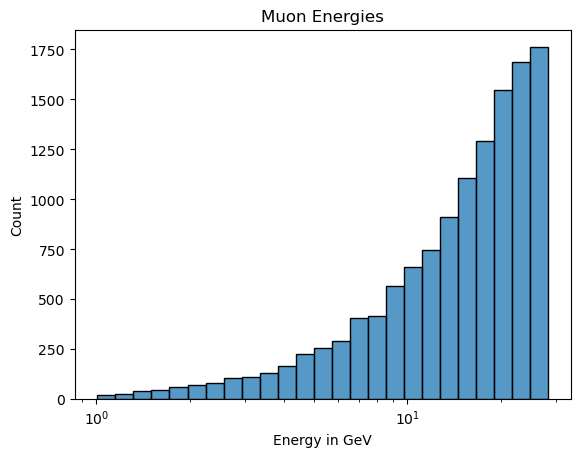

In [ ]:
#pyirf_weighted = np.array(pyirf_weighted)*1000
histplot(pyirf_weighted, log_scale = True, bins = 25)
plt.xlabel("Energy in GeV")
plt.title("Muon Energies")

mean =  0.2185614999277465
std =  0.0186516609245452
rel_err =  0.08533827289212048
len =  437


/var/folders/_p/3fmt5jz5231_9gxtm8xt76p00000gn/T/ipykernel_52848/2130044390.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  std_arr_1 = [np.std(opt_eff_m)/i**0.5 for i,j in enumerate(opt_eff_m)]


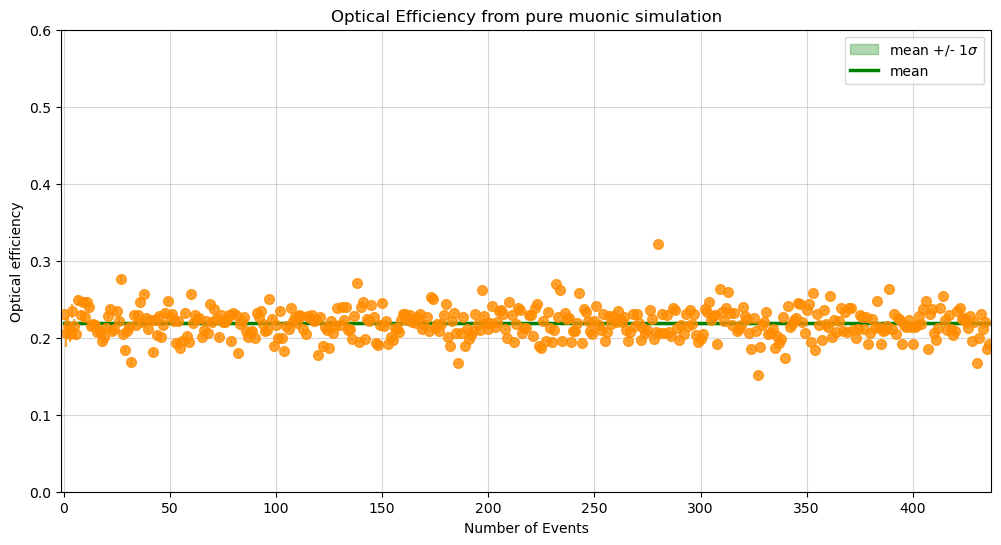

In [ ]:
#
#
# Images for events without cleaning
#
#

x_range_1 = [i for i in range(len(opt_eff_m))]
#std_arr = [np.std(opt_eff_m)/np.mean(opt_eff_m) for i,j in enumerate(opt_eff_m)]
std_arr_1 = [np.std(opt_eff_m)/i**0.5 for i,j in enumerate(opt_eff_m)]
std_arr_1_big = [np.std(opt_eff_m) for i,j in enumerate(opt_eff_m)]
#std_arr = [np.std(opt_eff) for i,j in enumerate(opt_eff)]


mean_range_1 = [i-1 for i in range(len(opt_eff_m)+3)]
y_upper_1 = [np.mean(opt_eff_m)+np.std(opt_eff_m) for i in mean_range_1]
y_lower_1 = [np.mean(opt_eff_m)-np.std(opt_eff_m) for i in mean_range_1]

y_mid_1 = [np.mean(opt_eff_m) for i in mean_range_1]
y_mid_1 = [np.mean(opt_eff_m[:i+1]) for i in range(len(opt_eff_m[:i+1]))]


#y_upper_1 = [j+std_arr_1[-1] for i,j in enumerate(y_mid_1)]
#y_lower_1 = [j-std_arr_1[-1] for i,j in enumerate(y_mid_1)]

y_upper_1 = [j+std_arr_1[-1] for i,j in enumerate(y_mid_1)]
y_lower_1 = [j-std_arr_1[-1] for i,j in enumerate(y_mid_1)]


#y_upper_1 = [j+np.std(opt_eff_m[:i+1]) for i,j in enumerate(y_mid_1)]
#y_lower_1 = [j-np.std(opt_eff_m[:i+1]) for i,j in enumerate(y_mid_1)]


y_upper_1 = [j+std_arr_1[-1] for i,j in enumerate([np.mean(opt_eff_m) for i in x_range_1])]
y_lower_1 = [j-std_arr_1[-1] for i,j in enumerate([np.mean(opt_eff_m) for i in x_range_1])]

plt.figure(figsize = (12,6))
#plt.ylim(0.095,0.34)

plt.style.use('default')
plt.xlim(-1,len(opt_eff_m))
plt.xlabel("Number of Events")
#plt.ylabel("Optical eff with rel. error for 1 measurment")
plt.ylabel("Optical efficiency")
#plt.title("Opt eff for muon rings without performing additional cleaning int_cut<0.1")
plt.title("Optical Efficiency from pure muonic simulation")
plt.grid(alpha=0.5)
plt.ylim(0,0.6)

#plt.scatter(x_range_1, opt_eff_m)
plt.errorbar(x_range_1, opt_eff_m, yerr=std_arr_1, fmt='o', ms = 7, alpha = 0.8, color = 'darkorange')#, c = 'blue')#, s = 100)#, c= 'black')


#plt.fill_between(x_range_1, y_upper_1, y_lower_1, color = 'green', alpha = 0.3, label = 'mean +/- $1\sigma$')
plt.fill_between(x_range_1, y_upper_1, y_lower_1, color = 'green', alpha = 0.3, label = 'mean +/- $1\sigma$')
#plt.plot(x_range_1, y_mid_1, label = "mean", c = 'green', linewidth = 1.5)
plt.plot(x_range_1, [np.mean(opt_eff_m) for i in x_range_1], label = "mean", c = 'green', linewidth = 2.5)


plt.legend()
print("mean = ", np.mean(opt_eff_m))
print("std = ", np.std(opt_eff_m))
print("rel_err = ", np.std(opt_eff_m)/np.mean(opt_eff_m))
print("len = ", len(opt_eff_m))
#plt.savefig("/Users/vdk/ImagePurgatorium/4LSTMuons_RelStd.png")

In [ ]:
#
# DISPLAY IMAGES
#

int_cut = 0.3
min_pixel = 70

muon_processor_config = Config({"MuonProcessor": 
                                {"RingQuery": 
                                 {"quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.5"],
                                                        ["ring_completeness", "parameters.completeness > 0.5"]]}}})

#muon_processor_config = Config({"MuonProcessor":
#                                {"ImageParameterQuery" :
#                                {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
#                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

muon_processor_config_2 = Config({"MuonProcessor":
                                {"ImageParameterQuery" :
                                 {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

checker = 0
event_container = {}
t1 = time.perf_counter(), time.process_time()

for k in range(1,101):
    filename = f'/Users/vdk/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    print(filename)
    source = EventSource(filename, max_events=9000)
    event_iterator = iter(source)
    keks = k*1000
    checker = 0
    for i,j in enumerate(event_iterator):
        for m in j.trigger.tels_with_trigger:
            event = j
            checker += 1
            image_processor = ImageProcessor(source.subarray)
            muon_processor = MuonProcessor(source.subarray, config = muon_processor_config_2)
            #muon_processor = MuonProcessor(source.subarray)
            calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
            calib(j)
            image_processor(j)
            muon_processor(j)
            plt.figure(figsize = (9,6))
            camgeom = source.subarray.tel[m].camera.geometry
            title=f"event_{i}_telescope_{m}"
            #title=f"CleanedRing_{i}_optEff{round(event_container[i].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[i].muon.tel[m].efficiency.width.to_value(),3)}_triggeredTel{m}"
            disp = CameraDisplay(camgeom,title=title)
            #disp.image = event_container[i].simulation.tel[m].true_image
            disp.image = j.r1.tel[m].waveform.sum(axis=1)
            disp.cmap = plt.cm.RdBu_r
            disp.add_colorbar()
            disp.set_limits_percent(95)
            reg_event_number.append(i)
            plt.show()
            plt.close()
    t2 = time.perf_counter(), time.process_time()
    print("checker = ", checker)   

print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

In [ ]:
len(event_container)

In [ ]:
filename = f'/Users/vdk/4LSTmuons/simtel_run101_muon.simtel.gz'
print(filename)
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)
event = next(event_iterator)

In [ ]:
# PROCESSING OF REGULAR IMAGES
lets_check = 0
opt_eff_cleaned = []
reg_event_number = []
for i in event_container:
    for m in event_container[i].trigger.tel.keys():
        if not np.isnan(event_container[i].muon.tel[m].efficiency.width):
                #plt.savefig(f"/Users/vdk/MRing_event{i}_fit{round(event_container[i].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[i].muon.tel[m].efficiency.width.to_value(),3)}.png")
                #plt.savefig(f"/Users/vdk/MRing_event{i}_fit{round(event_container[i].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[i].muon.tel[m].efficiency.width.to_value(),3)}.png")
                
                print("n_pixels ", event_container[i].dl1.tel[m].parameters.morphology.n_pixels)
                #print("MSE ", event_container[i].muon.tel[m].parameters.mean_squared_error)                
                #print("Muon parameters ", event_container[i].muon.tel[m].parameters)   
                #print("intensity_check ", abs(event_container[i].muon.tel[m].parameters.intensity_ratio - 1))
                #if event_container[i].dl1.tel[m].parameters.morphology.n_pixels > 50 and abs(event_container[i].muon.tel[m].parameters.intensity_ratio - 1) < 0.1:
                #if abs(event_container[i].muon.tel[m].parameters.intensity_ratio - 1) < 0.2:
                #print("n_pixels ", event_container[i].dl1.tel[m].parameters.morphology.n_pixels)
                #print("Muon parameters ", event_container[i].muon.tel[m].parameters)   
                #print("intensity_check ", abs(event_container[i].muon.tel[m].parameters.intensity_ratio - 1))
                lets_check+=1
                plt.figure(figsize = (9,6))
                camgeom = source.subarray.tel[m].camera.geometry
                title=f"Event_{i}_optEff{round(event_container[i].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[i].muon.tel[m].efficiency.width.to_value(),3)}_triggercount{len(event_container[i].trigger.tel.keys())}"
                #title=f"CleanedRing_{i}_optEff{round(event_container[i].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[i].muon.tel[m].efficiency.width.to_value(),3)}_triggeredTel{m}"
                disp = CameraDisplay(camgeom,title=title)
                disp.image = event_container[i].simulation.tel[m].true_image
                #disp.image = event_container[i].r1.tel[m].waveform.sum(axis=1)
                disp.cmap = plt.cm.RdBu_r
                disp.add_colorbar()
                disp.set_limits_percent(95)
                reg_event_number.append(i)
                plt.show()
                #plt.savefig(f"/Users/vdk/ImagePurgatorium/MuonsWithoutCleaning_intensitycut<0.3_event{i}.png")
                #opt_eff_cleaned.append(event_container[i].muon.tel[m].efficiency.optical_efficiency)
                    
plt.close()

In [ ]:
for m in event.trigger.tels_with_trigger:
    print(m)

In [ ]:
int_cut = 0.3
min_pixel = 70

muon_processor_config = Config({"MuonProcessor": 
                                {"RingQuery": 
                                 {"quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.5"],
                                                        ["ring_completeness", "parameters.completeness > 0.5"]]}}})

#muon_processor_config = Config({"MuonProcessor":
#                                {"ImageParameterQuery" :
#                                {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
#                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

muon_processor_config_2 = Config({"MuonProcessor":
                                {"ImageParameterQuery" :
                                 {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

checker = 0
event_container = {}
t1 = time.perf_counter(), time.process_time()

for k in range(1,101):
    filename = f'/Users/vdk/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    print(filename)
    source = EventSource(filename, max_events=9000)
    event_iterator = iter(source)
    keks = k*1000
    checker = 0
    for i,j in enumerate(event_iterator):
        if len(j.trigger.tels_with_trigger) > 1:
            for m in j.trigger.tels_with_trigger:
                plt.figure(figsize = (9,6))
                camgeom = source.subarray.tel[m].camera.geometry
                title=f"event_{i}_telescope_{m}"
                #title=f"CleanedRing_{i}_optEff{round(event_container[i].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[i].muon.tel[m].efficiency.width.to_value(),3)}_triggeredTel{m}"
                disp = CameraDisplay(camgeom,title=title)
                #disp.image = event_container[i].simulation.tel[m].true_image
                disp.image = j.r1.tel[m].waveform.sum(axis=1)
                disp.cmap = plt.cm.RdBu_r
                disp.add_colorbar()
                disp.set_limits_percent(95)
                reg_event_number.append(i)
                plt.show()
                plt.close()
            

In [ ]:
opt_eff = []

for i in event_container:
    for m in event_container[i].trigger.tels_with_trigger:
        opt_eff.append(event_container[i].muon.tel[m].efficiency.optical_efficiency)

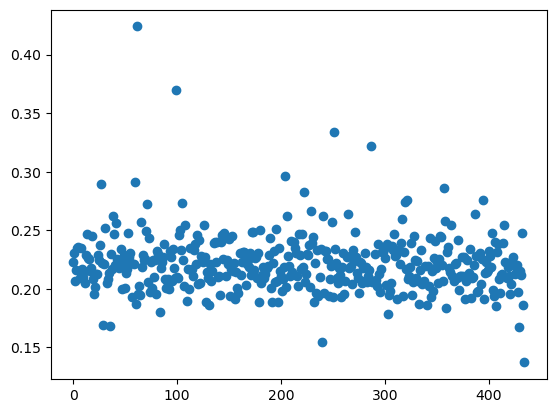

In [ ]:
x_values = [i for i in range(len(event_container))]
plt.scatter(x_values, opt_eff)

In [ ]:
np.mean(opt_eff)

0.22164693103583702

In [ ]:
len(opt_eff)

435

In [ ]:
from datetime import datetime

date_string = "21 June, 2018"

print("date_string =", date_string)
print("type of date_string =", type(date_string))

date_object = datetime.strptime(date_string, "%d %B, %Y")

print("date_object =", date_object)
print("type of date_object =", type(date_object))

date_string = 21 June, 2018
type of date_string = <class 'str'>
date_object = 2018-06-21 00:00:00
type of date_object = <class 'datetime.datetime'>


TypeError: function missing required argument 'year' (pos 1)

In [ ]:
testtime = event.trigger.tel[1].time.to_value("mjd", "str")

In [ ]:
date_string = testtime

print("date_string =", date_string)
print("type of date_string =", type(date_string))

date_object = datetime.strptime(date_string, "%d %B, %Y")

print("date_object =", date_object)
print("type of date_object =", type(date_object))

date_string = .0
type of date_string = <class 'str'>


ValueError: time data '.0' does not match format '%d %B, %Y'

In [ ]:
np.count_nonzero(event.simulation.tel[4].true_image)

34

In [ ]:
filename = f'/Users/vdk/LST/4LSTmuons/simtel_run101_muon.simtel.gz'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)


In [ ]:
event = next(event_iterator)

In [ ]:
print(np.max(event.r1.tel[3].waveform))

None


In [ ]:
image_processor = ImageProcessor(source.subarray)
muon_processor = MuonProcessor(source.subarray)
calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
calib(event)
image_processor(event)
muon_processor(event)

TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
/Users/vdk/mambaforge/envs/cta/lib/python3.11/site-packages/ctapipe/calib/camera/calibrator.py:159: UserWarning: Encountered an event with no R1 data. DL0 is unchanged in this circumstance.
  warnings.warn(
/Users/vdk/mambaforge/envs/cta/lib/python3.11/site-packages/ctapipe/calib/camera/calibrator.py:171: UserWarning: Encountered an event with no DL0 data. DL1 is unchanged in this circumstance.
  warnings.warn(


In [ ]:
print(event.r0.tel[4].waveform[1])

[[401 391 408 ... 398 395 400]
 [396 395 396 ... 407 407 398]
 [402 408 406 ... 412 395 397]
 ...
 [407 415 401 ... 408 402 407]
 [402 403 402 ... 401 395 392]
 [405 399 400 ... 395 399 410]]


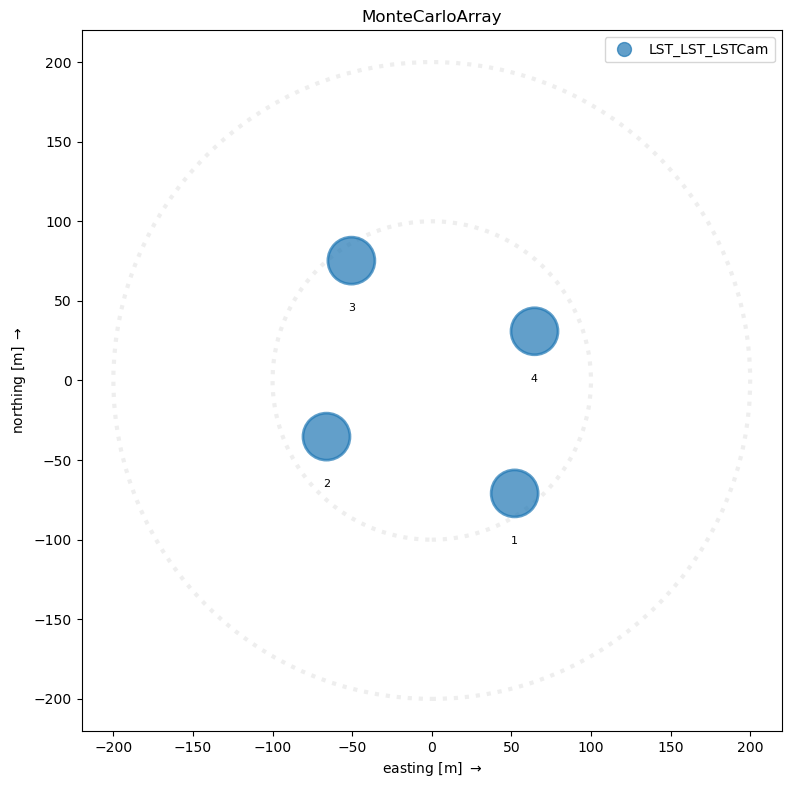

In [ ]:
source.subarray.peek()

In [ ]:
import pickle

In [ ]:
with open("/Users/vdk/pickle_dump_4LSTstereoMuons.pkl", "rb") as input_file:
    events = pickle.load(input_file)

In [ ]:
for event in events:
    print(event)

TypeError: attribute name must be string, not 'int'

In [ ]:
events.r1.tel[1].waveform

array([[-2.29919583e-01, -1.46188065e-01, -1.67120948e-01, ...,
         6.91127121e-01,  9.63254511e-01,  6.80660665e-01],
       [-1.11935556e-01, -1.22267857e-01, -2.25590855e-01, ...,
         1.71973754e-03, -8.09386596e-02, -1.63597047e-01],
       [-8.52358639e-02, -1.39399841e-01, -2.47727782e-01, ...,
         3.04744750e-01,  2.72246361e-01,  4.47576791e-02],
       ...,
       [-1.27470342e-03, -1.01122074e-01, -2.67534345e-01, ...,
        -1.27470342e-03,  2.87173241e-01,  2.09136009e-02],
       [-1.83116376e-01, -1.18901365e-01, -1.72413871e-01, ...,
        -6.53888583e-02,  9.52864904e-03,  5.23386523e-02],
       [-6.00255560e-04, -1.05670631e-01,  2.09540501e-01, ...,
        -2.42262125e-01, -2.31755093e-01, -1.89726934e-01]], dtype=float32)

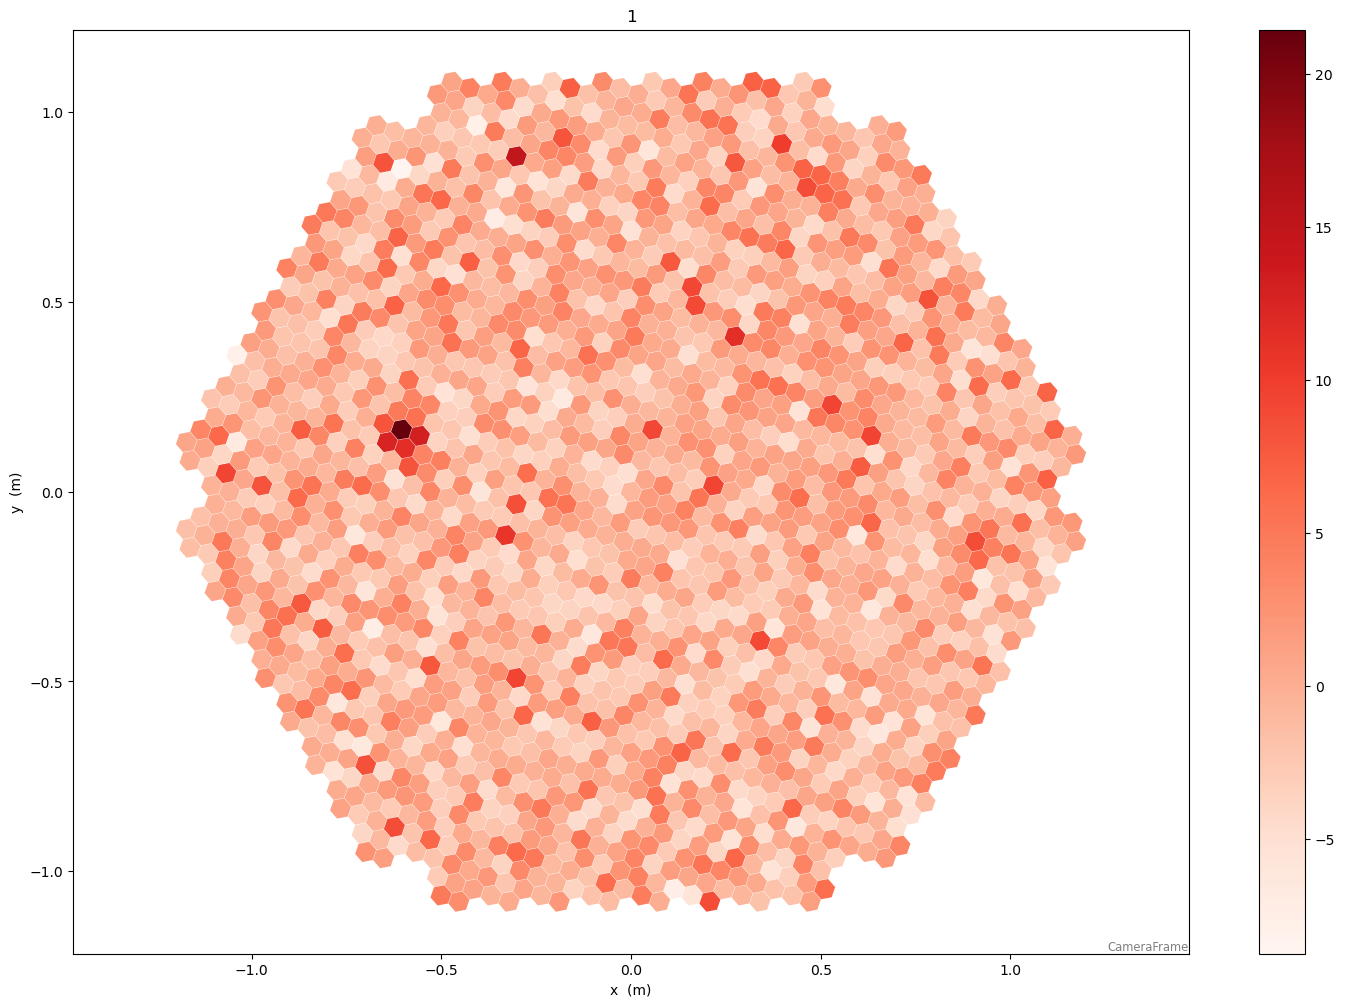

In [ ]:

plt.figure(figsize = (18,12))
camgeom = source.subarray.tel[1].camera.geometry
title = f'1'
disp = CameraDisplay(camgeom,title=title)
#disp.highlight_pixels(pixel_mask)
disp.image = events.r1.tel[4].waveform.sum(axis = 1)
disp.cmap = plt.cm.Reds
disp.add_colorbar()
disp.set_limits_percent(95)
#disp.set_limits_minmax(0,20)
plt.show()

In [ ]:
for tel in events.trigger.tels_with_trigger:
    print(tel)

1
4


In [ ]:
event.index.event_id

263800

## Prod6 FIXCHI200 production

In [76]:
int_cut = 0.3
min_pixel = 70
completeness = 0.9
containment = 0.5

muon_processor_config = Config({
                                "MuonProcessor": {
                                    "RingQuery": {
                                        "quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", f"parameters.containment > {containment}"],
                                                        ["ring_completeness", f"parameters.completeness > {completeness}"]]},
                                    "ImageParameterQuery" : {
                                        "quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]},
                                    "MuonIntensityFitter" : {
                                        "hole_radius_m" : [["type", "LST_*", 0.308]]
                                    }}})

checker = 0
event_container = {}
t1 = time.perf_counter(), time.process_time()
event_ids = []
impacts = []
widths = []


filename = f'/Users/vdk/UnrealLST/simtel_investigations/run901_muon.simtel.gz' # mono stereo
filename = f'/Users/vdk/UnrealLST/simtel_investigations/run1001_muon.simtel.gz' # stereo stereo

print(filename)
source = EventSource(filename)
event_iterator = iter(source)
checker = 0
for i,event in enumerate(event_iterator):
    for m in event.trigger.tels_with_trigger:
        checker += 1
        image_processor = ImageProcessor(source.subarray)
        muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
        calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
        
        #print(f"Non Muon Event Telescope with stereo trigger = {event.trigger.tels_with_trigger}")
        calib(event)
        image_processor(event)
        muon_processor(event)
        for tel in event.trigger.tels_with_trigger:
            if not np.isnan(event.muon.tel[tel].efficiency.width):
                plt.figure(figsize = (9,6))
                camgeom = source.subarray.tel[1].camera.geometry
                title = f'event {event.index.event_id} in telescope {tel} and energy = {event.shower.simulation.energy}'
                disp = CameraDisplay(camgeom,title=title)
                disp.image = event.dl1.tel[tel].image
                disp.cmap = plt.cm.Reds
                disp.add_colorbar()
                disp.set_limits_percent(95)
                plt.show()
                print(f"Muon Event Telescope with stereo trigger = {event.trigger.tels_with_trigger}")
                event_container[i] = event
                event_ids.append(event.index.event_id)
                impacts.append(event.muon.tel[tel].efficiency.impact)
                widths.append(event.muon.tel[tel].efficiency.width)
t2 = time.perf_counter(), time.process_time()
print("checker = ", checker)   
plt.close()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

/Users/vdk/UnrealLST/simtel_investigations/run1001_muon.simtel.gz
checker =  6
 Real time: 1.36 seconds
 CPU time: 1.17 seconds


In [10]:
event_container.keys()

dict_keys([83, 560, 665, 837, 1101, 1119, 2353])

In [14]:
event_container[83].trigger.tels_with_trigger

array([2, 3, 4], dtype=int16)

In [25]:
print(event_container[83].simulation.shower)

{'alt': <Angle 1.56107962 rad>,
 'az': <Angle 2.54967785 rad>,
 'core_x': <Quantity 79.53858185 m>,
 'core_y': <Quantity 50.98420334 m>,
 'energy': <Quantity 0.06837192 TeV>,
 'h_first_int': <Quantity 1. m>,
 'shower_primary_id': 2,
 'x_max': <Quantity 230. g / cm2>}


In [21]:
print(event_container[83].muon.tel[3].efficiency)

{'impact': <Quantity 4.90034179 m>,
 'impact_x': <Quantity 1.89213456 m>,
 'impact_y': <Quantity -4.52030712 m>,
 'optical_efficiency': 0.20489984610591971,
 'width': <Quantity 0.02718199 deg>}


In [22]:
print(event_container[83].muon.tel[4].efficiency)

{'impact': <Quantity nan m>,
 'impact_x': <Quantity nan m>,
 'impact_y': <Quantity nan m>,
 'optical_efficiency': nan,
 'width': <Quantity nan deg>}


In [77]:
event

ctapipe.containers.ArrayEventContainer:
                       index.*: event indexing information with default None
                          r0.*: Raw Data with default None
                          r1.*: R1 Calibrated Data with default None
                         dl0.*: DL0 Data Volume Reduced Data with default None
                         dl1.*: DL1 Calibrated image with default None
                         dl2.*: DL2 reconstruction info with default None
                  simulation.*: Simulated Event Information with default None
                                with type <class
                                'ctapipe.containers.SimulatedEventContainer'>
                     trigger.*: central trigger information with default None
                         count: number of events processed with default 0
                    pointing.*: Array and telescope pointing positions with
                                default None
                 calibration.*: Container for calibra

In [68]:
print(event.pointing)

{'array_altitude': <Quantity 1.5707964 rad>,
 'array_azimuth': <Quantity 3.1415927 rad>,
 'array_dec': <Quantity nan rad>,
 'array_ra': <Quantity nan rad>,
 'tel': {1: {'altitude': <Quantity 1.57079633 rad>,
             'azimuth': <Quantity 3.1415927 rad>},
         3: {'altitude': <Quantity 1.57079633 rad>,
             'azimuth': <Quantity 3.1415927 rad>}}}


In [63]:
print(event.trigger.tel[3])

{'n_trigger_pixels': -1,
 'time': <Time object: scale='utc' format='jd' value=2460285.604986047>,
 'trigger_pixels': None}


In [70]:
source.subarray.tel[1]

TelescopeDescription(type='LST', optics_name='LST', camera_name='LSTCam')

TelescopeDescription(type='LST', optics_name='LST', camera_name='LSTCam')

In [90]:
print(source.subarray.tel[1].camera.geometry)

LSTCam


In [93]:
print(source.subarray.tel)

{1: TelescopeDescription(type='LST', optics_name='LST', camera_name='LSTCam'), 2: TelescopeDescription(type='LST', optics_name='LST', camera_name='LSTCam'), 3: TelescopeDescription(type='LST', optics_name='LST', camera_name='LSTCam'), 4: TelescopeDescription(type='LST', optics_name='LST', camera_name='LSTCam')}


In [12]:
source.subarray.tels

{1: TelescopeDescription(type='LST', optics_name='LST', camera_name='LSTCam'),
 2: TelescopeDescription(type='LST', optics_name='LST', camera_name='LSTCam'),
 3: TelescopeDescription(type='LST', optics_name='LST', camera_name='LSTCam'),
 4: TelescopeDescription(type='LST', optics_name='LST', camera_name='LSTCam')}

/Users/vdk/Software/ctasoft/calibpipe/calibpipe/tests/data/throughput/run101_muon_mst.simtel.gz
[1]


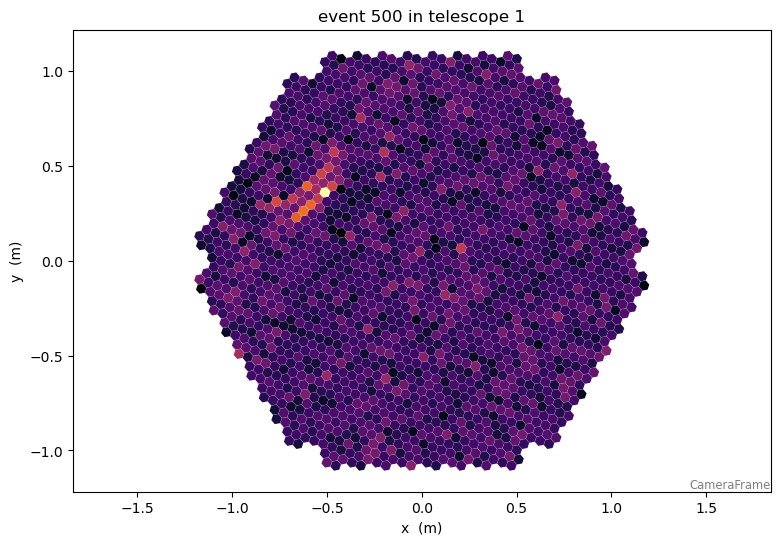

[1]


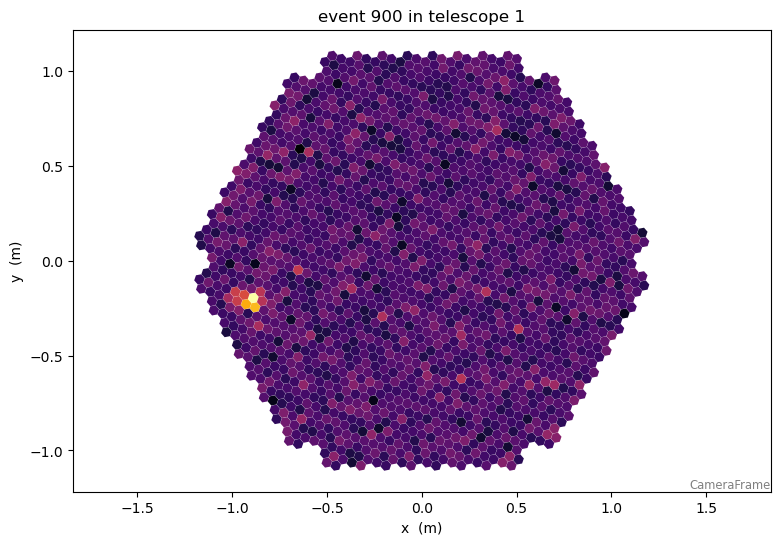

[1]


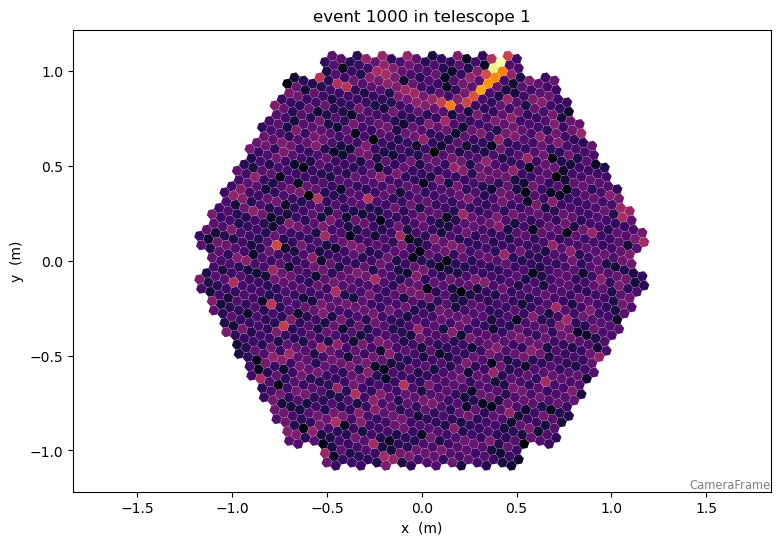

[1]


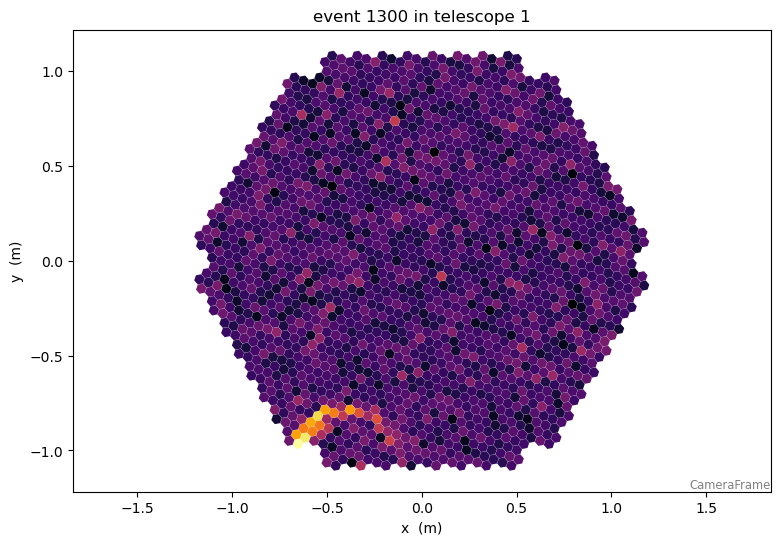

[1]


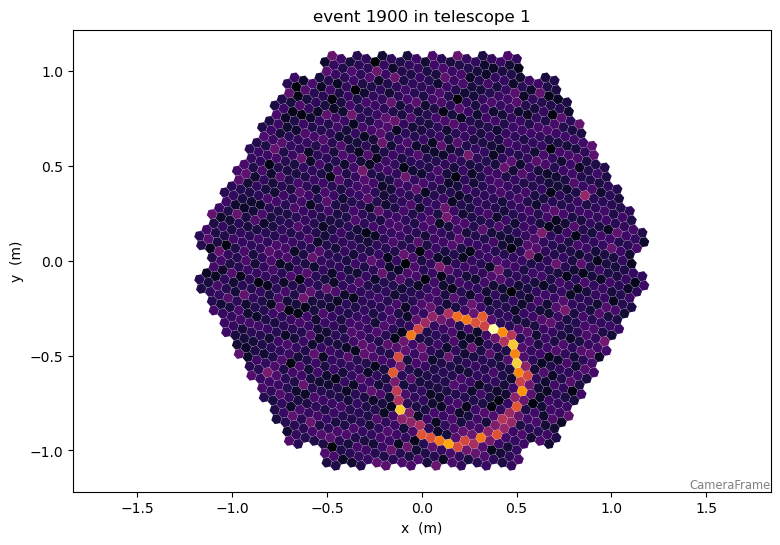

[1]


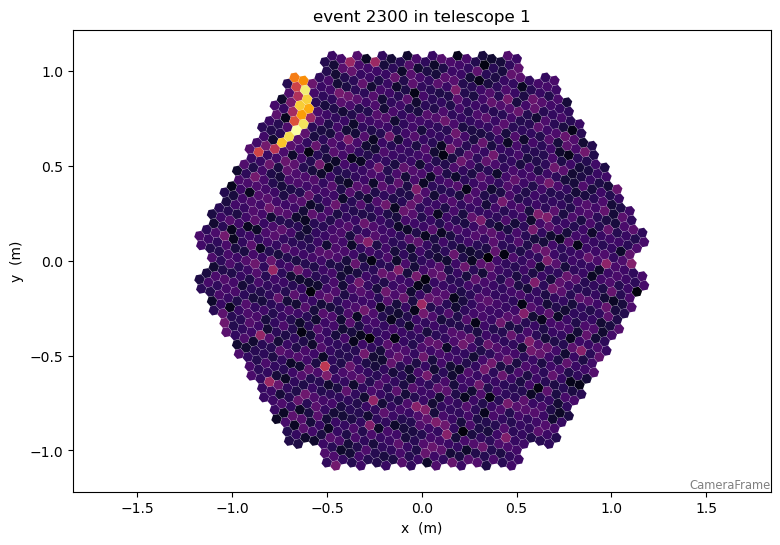

[1]


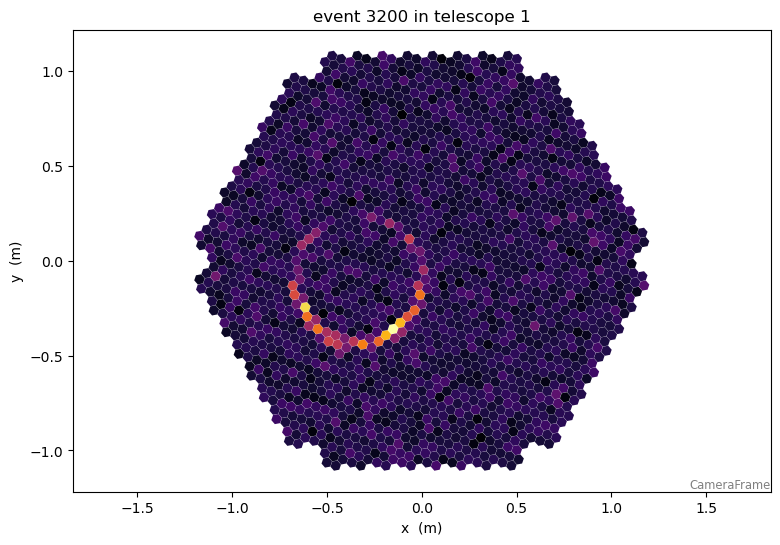

[1]


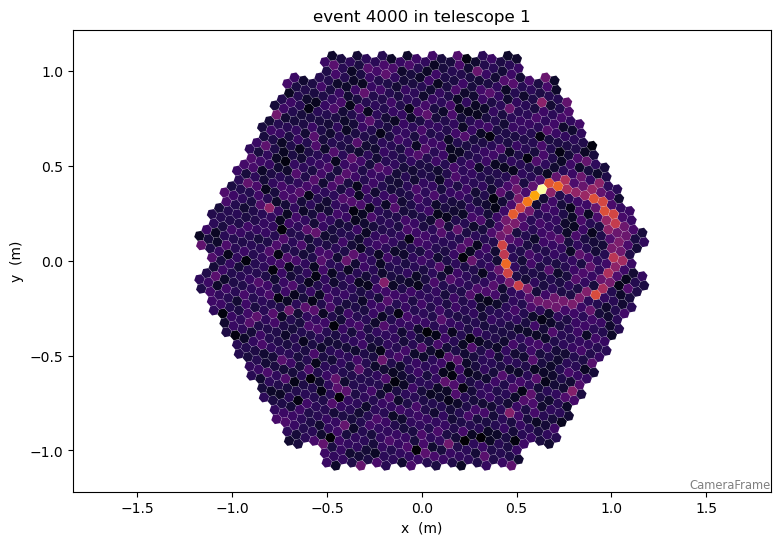

[1]


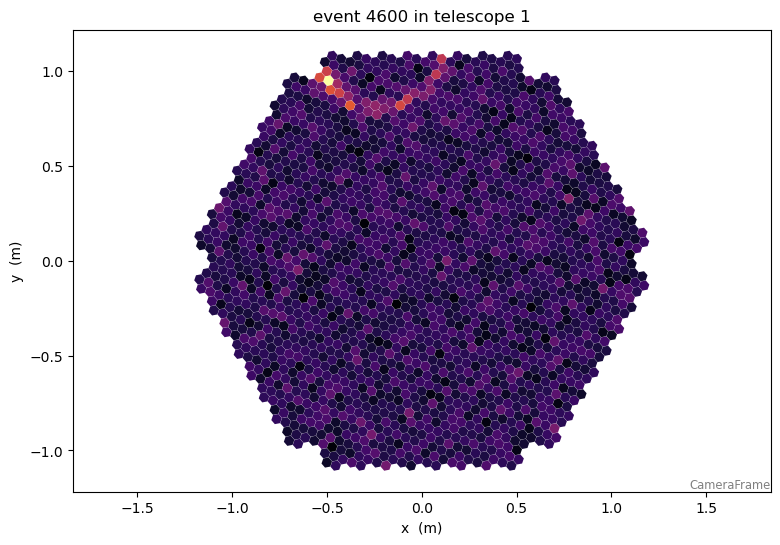

[1]


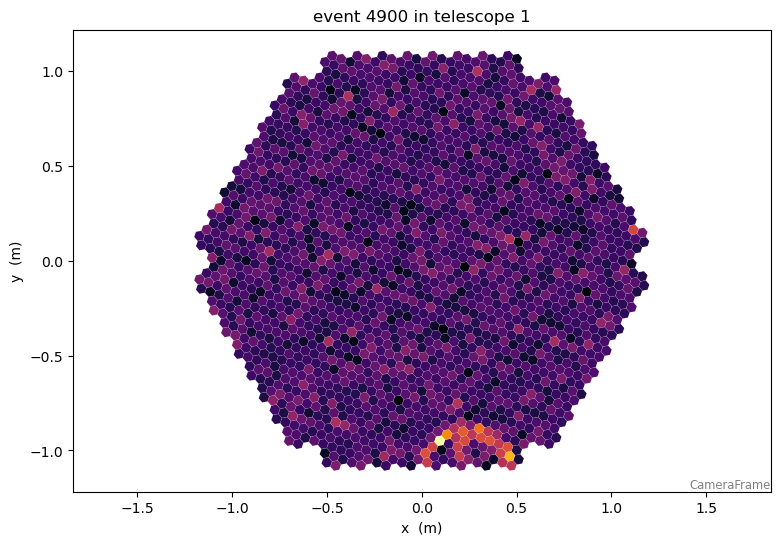

[1]


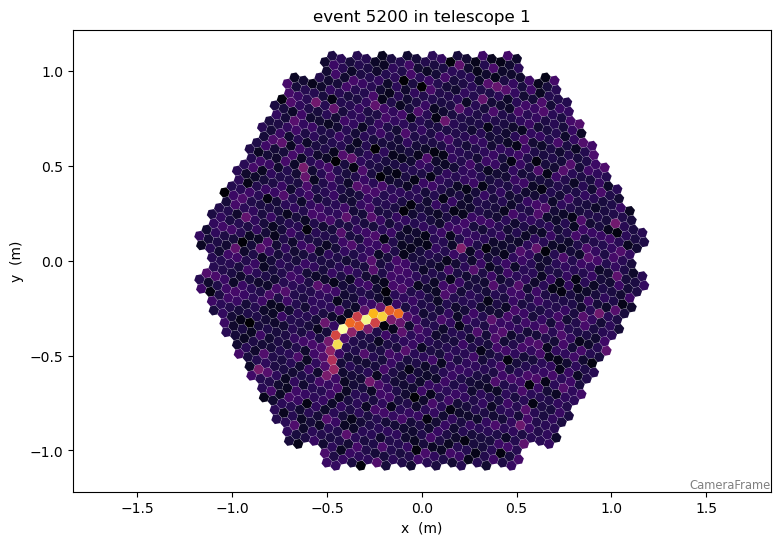

[1]


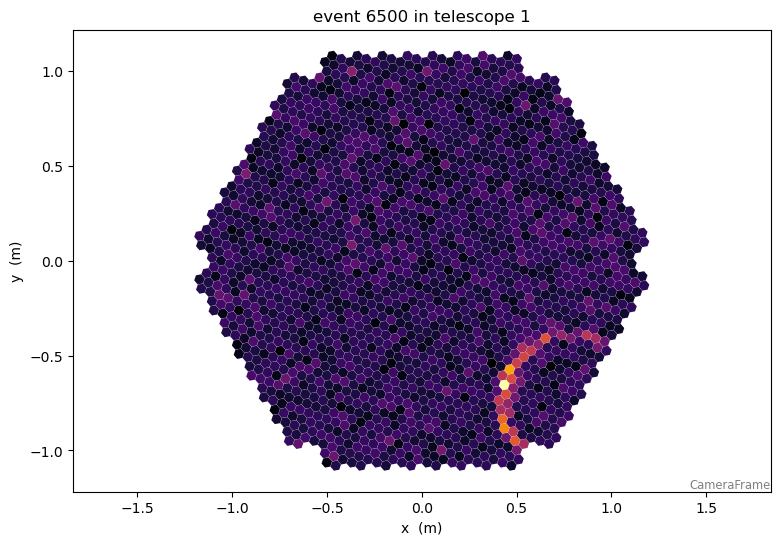

[1]


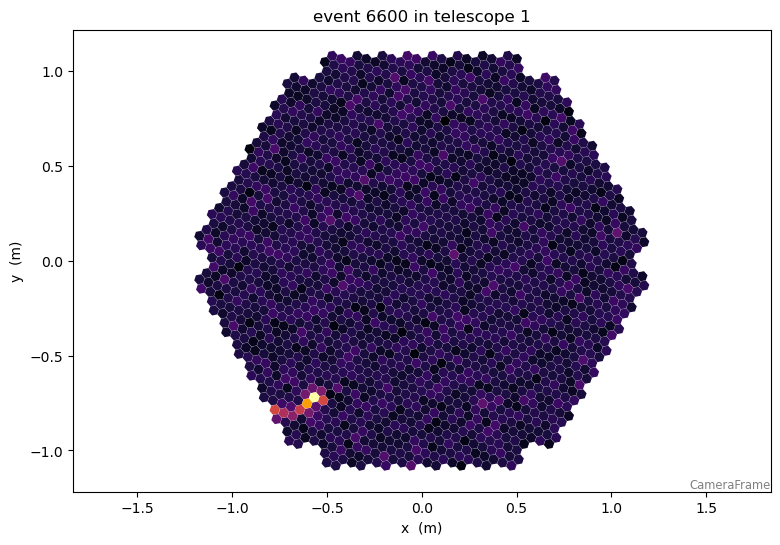

[1]


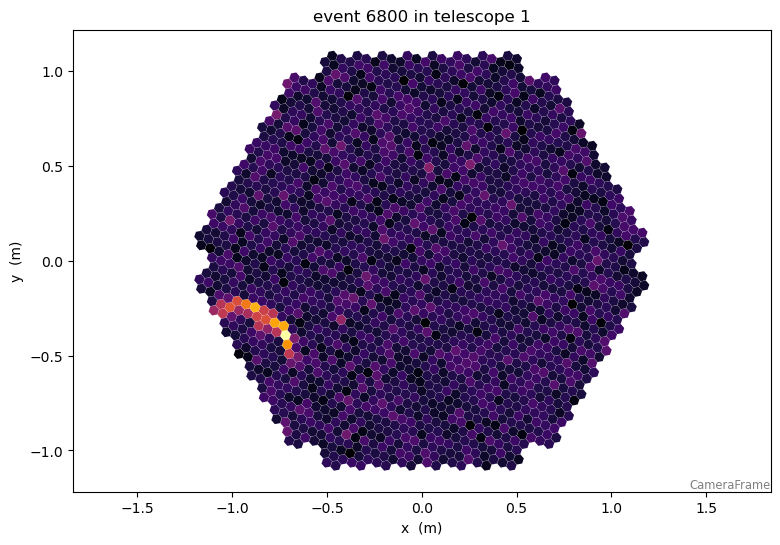

[1]


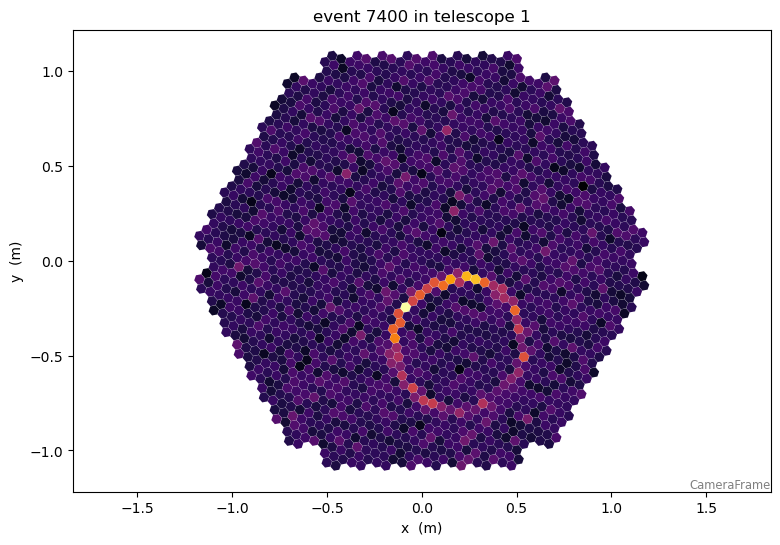

[1]


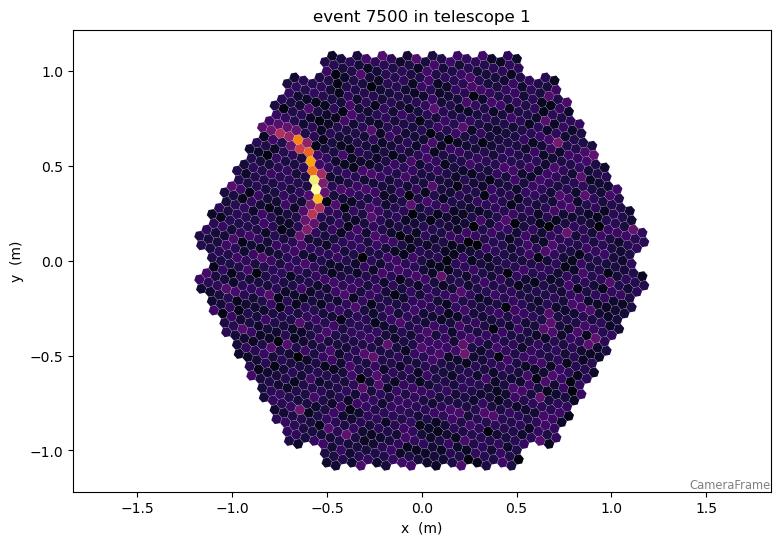

[1]


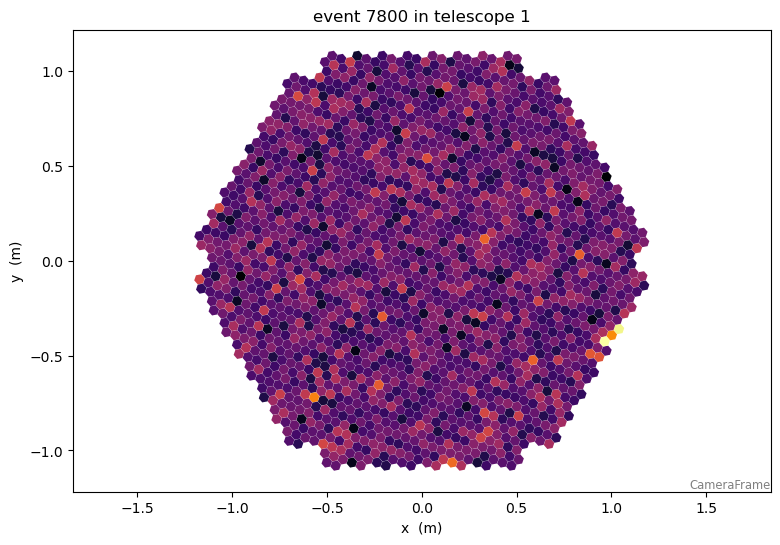

[1]


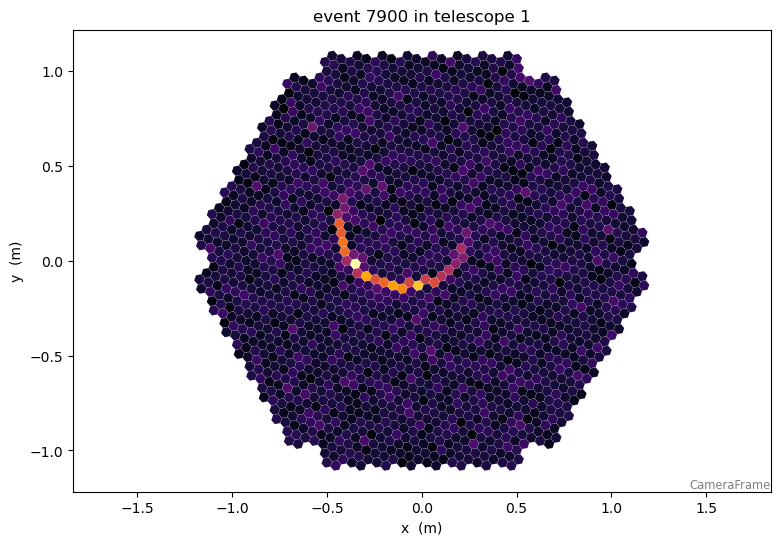

[1]


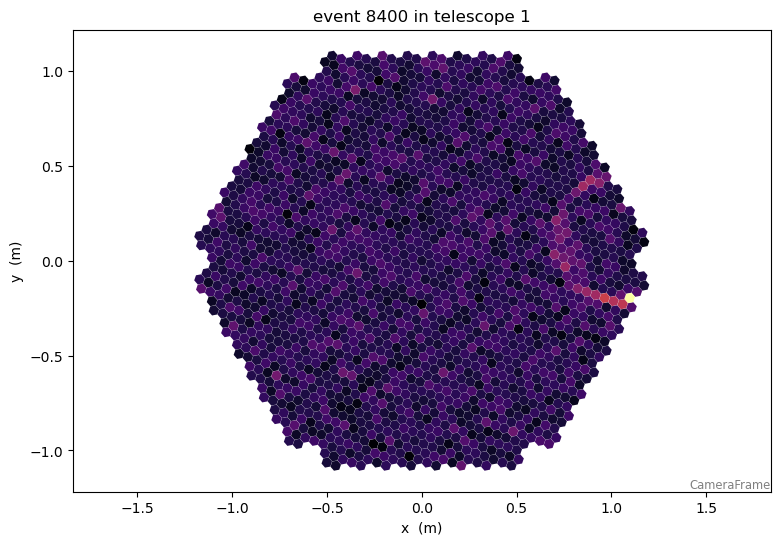

[1]


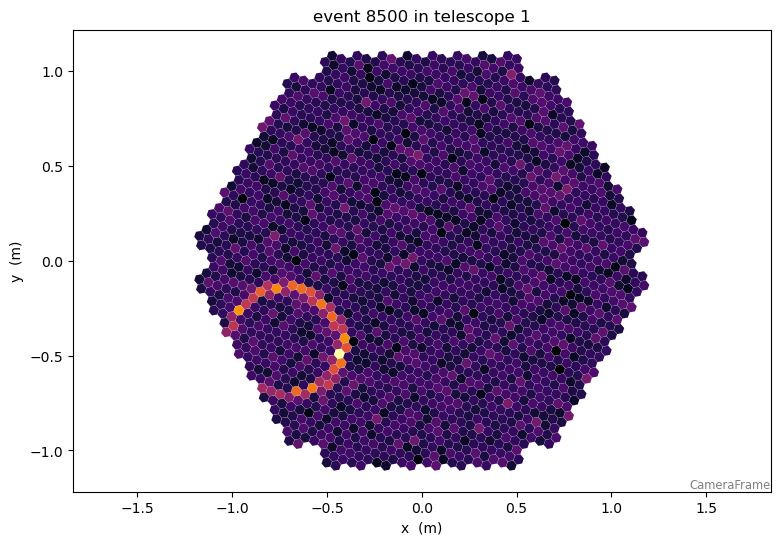

[1]


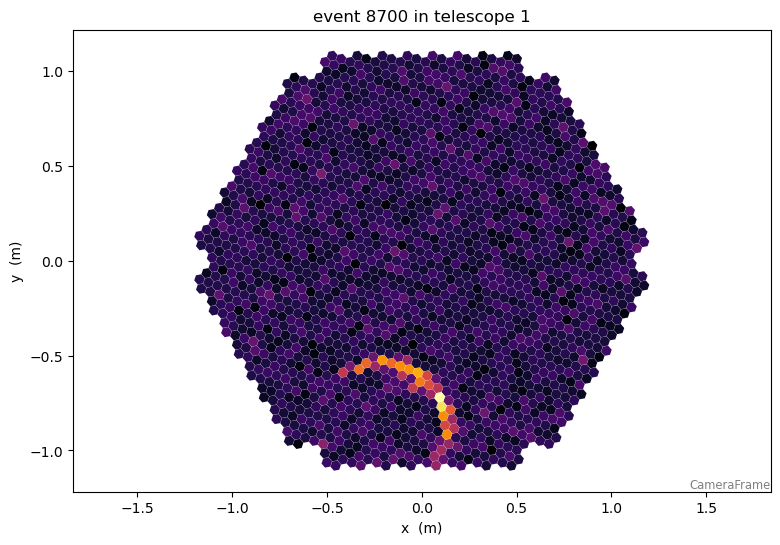

[1]


KeyboardInterrupt: 

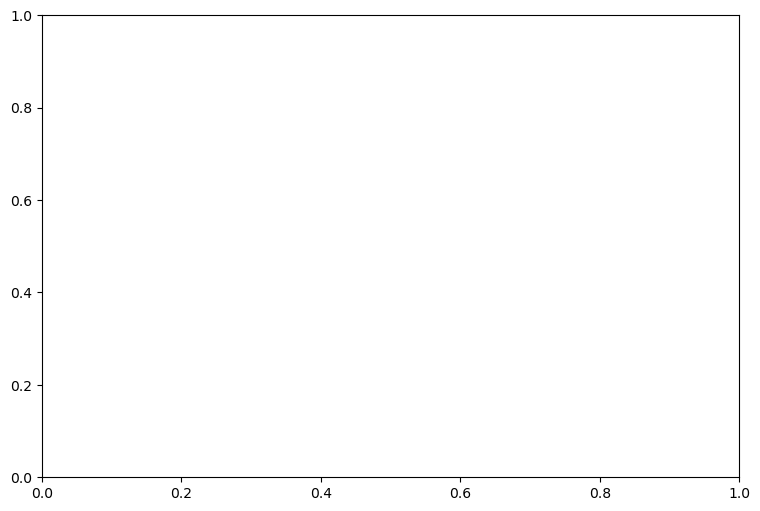

In [33]:
int_cut = 0.3
min_pixel = 70

# MuonIntensityFitter : 
#   hole_radius_m : [["type", "LST_*", 0.308]]

# muon_processor_config = Config({"MuonProcessor": 
#                                 {"RingQuery": 
#                                  {"quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
#                                                         ["ring_containment", "parameters.containment > 0.5"],
#                                                         ["ring_completeness", "parameters.completeness > 0.5"]]}}})

# #muon_processor_config = Config({"MuonProcessor":
# #                                {"ImageParameterQuery" :
# #                                {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
# #                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

# muon_processor_config_2 = Config({"MuonProcessor":
#                                 {"ImageParameterQuery" :
#                                  {"quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
#                                                         ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})


muon_processor_config = Config({
                                "MuonProcessor": {
                                    "RingQuery": {
                                        "quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.3"],
                                                        ["ring_completeness", "parameters.completeness > 0.3"]]},
                                    "ImageParameterQuery" : {
                                        "quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]},
                                    "MuonIntensityFitter" : {
                                        "hole_radius_m" : [["type", "MST_*", 0.108]]
                                    }}})

checker = 0
event_container = {}
t1 = time.perf_counter(), time.process_time()
event_ids = []
impacts = []
widths = []
filename = f'/Users/vdk/Software/ctasoft/calibpipe/calibpipe/tests/data/throughput/run101_muon_mst.simtel.gz'
print(filename)
source = EventSource(filename)
event_iterator = iter(source)
checker = 0
for i,event in enumerate(event_iterator):
    for m in event.trigger.tels_with_trigger:
        print(event.trigger.tels_with_trigger)
        checker += 1
        image_processor = ImageProcessor(source.subarray)
        muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
        #muon_processor = MuonProcessor(source.subarray)
        calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
        #print(f"Non Muon Event Telescope with stereo trigger = {event.trigger.tels_with_trigger}")
        calib(event)
        image_processor(event)
        muon_processor(event)
        plt.figure(figsize = (9,6))
        camgeom = source.subarray.tel[1].camera.geometry
        title = f'event {event.index.event_id} in telescope {m}'
        disp = CameraDisplay(camgeom,title=title)
        disp.image = event.r1.tel[1].waveform.sum(axis = 1)
        # disp.image = event.dl1.tel[m].image
        # disp.cmap = plt.cm.Reds
        # disp.add_colorbar()
        # disp.set_limits_percent(95)
        plt.show()
        for m in event.muon.tel.keys():
            if not np.isnan(event.muon.tel[m].efficiency.width):
                #print("I am here")
                plt.figure(figsize = (9,6))
                camgeom = source.subarray.tel[1].camera.geometry
                title = f'event {event.index.event_id} in telescope {m}'
                disp = CameraDisplay(camgeom,title=title)
                disp.image = event.r1.tel[m].waveform.sum(axis = 1)
                # disp.image = event.dl1.tel[m].image
                # disp.cmap = plt.cm.Reds
                # disp.add_colorbar()
                # disp.set_limits_percent(95)
                plt.show()
                #print(f"Muon Event Telescope with stereo trigger = {event.trigger.tels_with_trigger}")
                event_container[keks+i] = event
                event_ids.append(event.index.event_id)
                impacts.append(event.muon.tel[m].efficiency.impact)
                widths.append(event.muon.tel[m].efficiency.width)
t2 = time.perf_counter(), time.process_time()
print("checker = ", checker)   
#plt.close()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

In [29]:
source.subarray.positions

{1: <Quantity [0., 0., 9.] m>}

In [24]:
source.subarray.__dir__()

['name',
 'positions',
 'tels',
 'reference_location',
 'tel_coords',
 'tel_ids',
 'tel_indices',
 'tel_index_array',
 'telescope_types',
 '__module__',
 '__doc__',
 'CURRENT_TAB_VERSION',
 'COMPATIBLE_VERSIONS',
 '__init__',
 '__str__',
 '__repr__',
 'tel',
 'n_tels',
 '__len__',
 'info',
 'tel_ids_to_indices',
 'tel_ids_to_mask',
 'tel_mask_to_tel_ids',
 'footprint',
 'to_table',
 'select_subarray',
 'peek',
 'camera_types',
 'optics_types',
 'get_tel_ids_for_type',
 'get_tel_indices_for_type',
 'multiplicity',
 'get_tel_ids',
 '__eq__',
 'to_hdf',
 'from_hdf',
 'read',
 '__dict__',
 '__weakref__',
 '__hash__',
 '__new__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [22]:
event.trigger

array([1], dtype=int16)